# Data4Good Case Challenge



![Data4Good](Data4Good.png)





# Data4Good Competition – AI Factuality Detection Report
1. Executive Summary

AI-generated educational content can be factual, contradictory, or irrelevant. Large language models often hallucinate or provide misleading answers, posing a risk for learners.

We explored three modeling approaches:

- TF-IDF + Logistic Regression – baseline capturing lexical overlap.
- Sentence Embeddings + Logistic Regression – semantic baseline.
- Two-Stage Decomposed System – final model, separates relevance and factuality to reduce noise.

Outcome:
The two-stage system achieved the best balance of precision and recall, particularly reducing irrelevant content and contradiction→factual misclassifications.

2. Data Overview

Original dataset: 21,021 rows × 4 columns (answer, type, context, question).

Missing values: 1,869 contexts removed, resulting in 19,152 usable rows.

Label distribution after cleaning:

- Factual (0): 17,431
- Contradiction (1): 1,818
- Irrelevant (2): 1,772

Observations:

Answers are generally short (~5–20 tokens).

Contexts are longer, averaging ~100–150 tokens.

Irrelevant answers tend to have low semantic similarity to questions and context.

Token length distributions for answers, context, and question are shown in the figure below:

![image-1](image-1.png)

3. Exploratory Data Analysis (EDA)

Answer, Context, and Question lengths were analyzed by label.

Semantic similarity analysis (cosine with embeddings) highlighted:

- Factual: high similarity to both question and context.
- Contradiction: high similarity but incorrect polarity.
- Irrelevant: low similarity to question and context.

![image-2](image-2.png)

These insights guided our modeling choices: Model 1 captures lexical cues, Model 2 captures semantic meaning, and Model 3 decomposes the problem to improve relevance and factuality detection.

4. Model 1 – TF-IDF + Logistic Regression

Input: Concatenated [Question + Context + Answer].
Features: TF-IDF (1–2 grams).

Results:

- Accuracy: 64.13%
- Macro-F1: 0.3632

Classification Report Highlights:

- Factual: F1 = 0.78
- Contradiction: F1 = 0.16
- Irrelevant: F1 = 0.14

Observations:

Strong lexical signal for factual content.

Poor performance for contradiction and irrelevant, likely due to keyword overlap misrepresenting factuality.

![image-3](image-3.png)

5. Model 2 – Sentence Embeddings + Logistic Regression

Input: [Question + Context + Answer] embeddings using all-MiniLM-L6-v2.

Results:

- Accuracy: 93.40%
- Macro-F1: 0.7994

Classification Report Highlights:

- Factual: F1 = 0.9737
- Contradiction: F1 = 0.5563
- Irrelevant: F1 = 0.8683

Observations:

Semantic embeddings greatly improve relevance and factuality detection.

Some confusion persists between contradiction and factual content.

![image-4](image-4.png)

6. Model 3 – Two-Stage Decomposed System (Final Model)

Stage 1 – Relevance Classifier

Binary classification: Relevant (Factual + Contradiction) vs Irrelevant.

Accuracy: 99%

Macro-F1: 0.97

Key observation: Almost all irrelevant content removed, reducing noise for Stage 2.

Stage 2 – Factuality Classifier

Binary classification: Factual vs Contradiction (trained only on relevant samples).

Accuracy: 87%

Macro-F1: 0.74

Key observation: Correctly identifies most factual content; contradiction detection improved compared to baselines.

![image-5](image-5.png)

Final Prediction Logic:

If Stage 1 = Irrelevant → Irrelevant
Else → Stage 2 output (Factual or Contradiction)


Advantages:

- Separates topic relevance from factuality reasoning.
- Reduces contradiction → factual mislabels.
- Allows lightweight models to achieve high performance without full transformer fine-tuning.

7. Model Comparison

![image](image.png)

*Approximate combined metric from Stage 1 + Stage 2.

8. Conclusion & Recommendations

Two-stage decomposed system is the competitive approach for factuality detection.

Stage 1 removes irrelevant answers early, Stage 2 focuses on factuality vs contradiction.

This method improves macro-F1 and reduces misclassification errors in a computationally efficient way.

Future work:

Incorporate external knowledge validation for factual verification.

Experiment with lightweight transformers for Stage 2.

Ensemble multiple embedding models for semantic robustness.

In [1]:
import pandas as pd
import json

# Load the train.json file
data_path = "data/train.json"
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
train_df = pd.DataFrame(data)

# Show the first 50 rows
train_df.head(50)

,answer,type,context,question
0,"In 1512, Parliament passed a significant act t...",factual,During the Hundred Years' War a French attack ...,In what year did Parliament pass a notable law...
1,The Spanish and French were the ones who estab...,factual,"""By May 1539, Conquistador Hernando de Soto sk...",Who established early settlements in Florida
2,"Traditionally, monsoons in Punjab are expected...",factual,The onset of the southwest monsoon is anticipa...,When do monsoons traditionally happen in Punjab?
3,The media made the requests for Kondo to use o...,factual,Media requests at the trade show prompted Kond...,Who made the requests for Kondo to use orchest...
4,According to historians Robert Friedel and Pau...,factual,In addressing the question of who invented the...,How many inventors came up with electric lamps...
5,The process that can increase solar energy pot...,factual,,What is the process called that can increase s...
6,The main focus of the 5th season is the Digita...,factual,"After a three-year hiatus, a fifth Digimon ser...",What was the main focus of the 5th season?
7,The mean annual temperature in Hyderabad is 26...,factual,Hyderabad has a tropical wet and dry climate (...,What is the mean yearly temperature in Hyderab...
8,The issue of through traffic benefits can aris...,factual,Network effects are a large factor with electr...,Where can the issue of through traffic benefit...
9,Montini's office received nearly ten million i...,irrelevant,,Fireworks are discharged on New Year's Eve fro...


In [2]:
# Print basic info
print("Number of raws:", train_df.shape[0])
print("Number of columns:", train_df.shape[1])
print("\nColumn names:", train_df.columns.tolist)

Number of raws: 21021
Number of columns: 4

Column names: <bound method IndexOpsMixin.tolist of Index(['answer', 'type', 'context', 'question'], dtype='object')>


In [3]:
# Check for duplicate indices (IDs)
if 'index' in train_df.columns:
    duplicate_ids = train_df['index'].duplicate().sum()
    print('number of duplicated IDs:', duplicate_ids)
else:
    print("No 'index' column found for ID check.")


No 'index' column found for ID check.


In [4]:
# Checking for missing or empty fields
missing_context = train_df['context'].isnull().sum() + (train_df['context'].str.strip()== '').sum()
missing_question = train_df['question'].isnull().sum() + (train_df['question'].str.strip()== '').sum()
missing_answer = train_df['answer'].isnull().sum() + (train_df['answer'].str.strip()== '').sum()

print(f'missing/empty contexts: {missing_context}')
print(f'missing/empty question: {missing_question}')
print(f'missing/empty answer: {missing_answer}')

missing/empty contexts: 1869
missing/empty question: 0
missing/empty answer: 0


In [5]:
# Label Encoding
label_mapping = {'factual': 0, 'contradiction': 1, 'irrelevant': 2}
train_df['label'] = train_df['type'].map(label_mapping)

print('\nLabel value counts:')
print(train_df['label'].value_counts())


Label value counts:
label
0    17431
1     1818
2     1772
Name: count, dtype: int64


In [6]:
# Drop rows with missing or empty 'context'
train_df['context'] = train_df['context'].astype(str)
train_df = train_df[train_df['context'].str.strip() != '']

print('Remaining rows after dropping empty contexts:', train_df.shape[0])
print('Remaining missing/empty contexts:', train_df['context'].isnull().sum() + (train_df['context'].str.strip() == ''). sum())

Remaining rows after dropping empty contexts: 19152
Remaining missing/empty contexts: 0


# EDA - Modelling Decisons(Directly Connected)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

2026-01-09 04:52:40.151297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767934360.166245     381 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767934360.170859     381 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767934360.183089     381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767934360.183103     381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767934360.183105     381 computation_placer.cc:177] computation placer alr

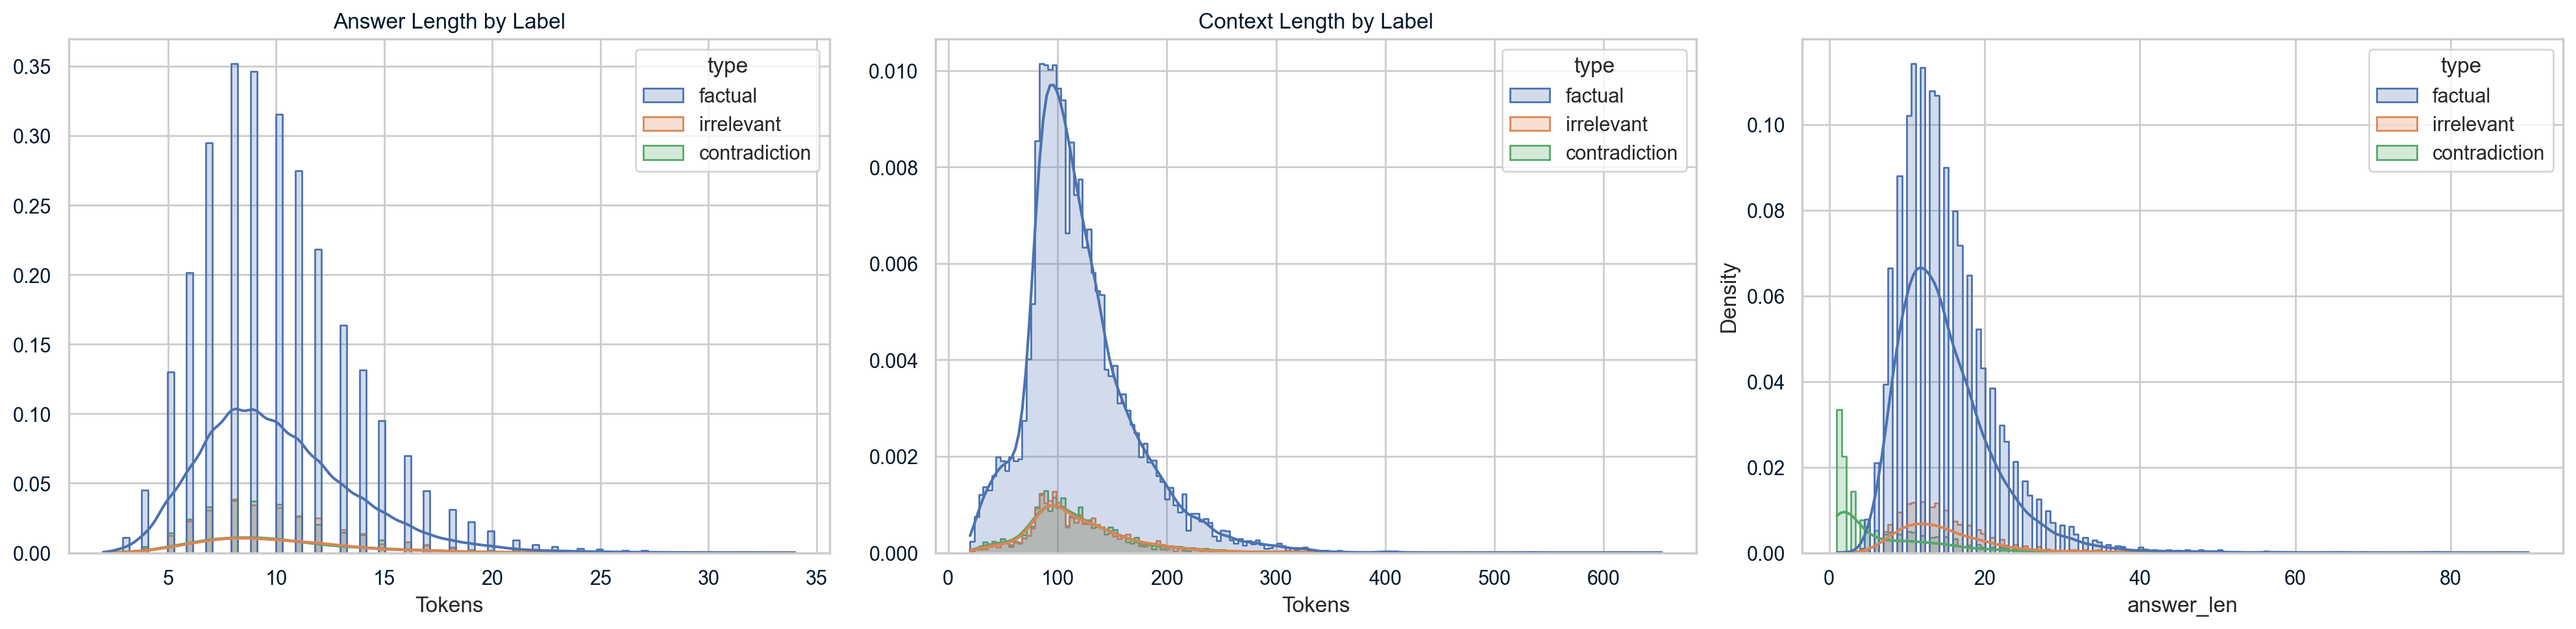

In [8]:
# Compute token counts / length
train_df['question_len'] = train_df['question'].str.split().apply(len)
train_df['context_len'] = train_df['context'].str.split().apply(len)
train_df['answer_len'] = train_df['answer'].str.split().apply(len)

# Visualize lenght distribution
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Question lenght distribution
sns.histplot(train_df, x='question_len', hue='type', kde=True, element='step', stat='density', ax=axes[0])
axes[0].set_title('Question Length by Label')
axes[0].set_xlabel('Tokens')
axes[0].set_ylabel('')

# Context length distribution
sns.histplot(train_df, x='context_len', hue='type', kde=True, element='step', stat='density', ax=axes[1])
axes[1].set_title('Context Length by Label')
axes[1].set_xlabel('Tokens')
axes[1].set_ylabel('')

# Answer length distribution
sns.histplot(train_df, x='answer_len', hue='type', kde=True, element='step', stat='density', ax=axes[2])
axes[0].set_title('Answer Length by Label')
axes[0].set_xlabel('Tokens')
axes[0].set_ylabel('')

plt.tight_layout()
plt.show()


In [9]:
# Computing semantic similarity
# Using a pretrained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2') # small but fast for 21k rows

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
# Compute embeddings
question_embeddings = model.encode(train_df['question'].tolist(), convert_to_tensor=True)
context_embeddings = model.encode(train_df['context'].tolist(), convert_to_tensor=True)
answer_embeddings = model.encode(train_df['answer'].tolist(), convert_to_tensor=True)

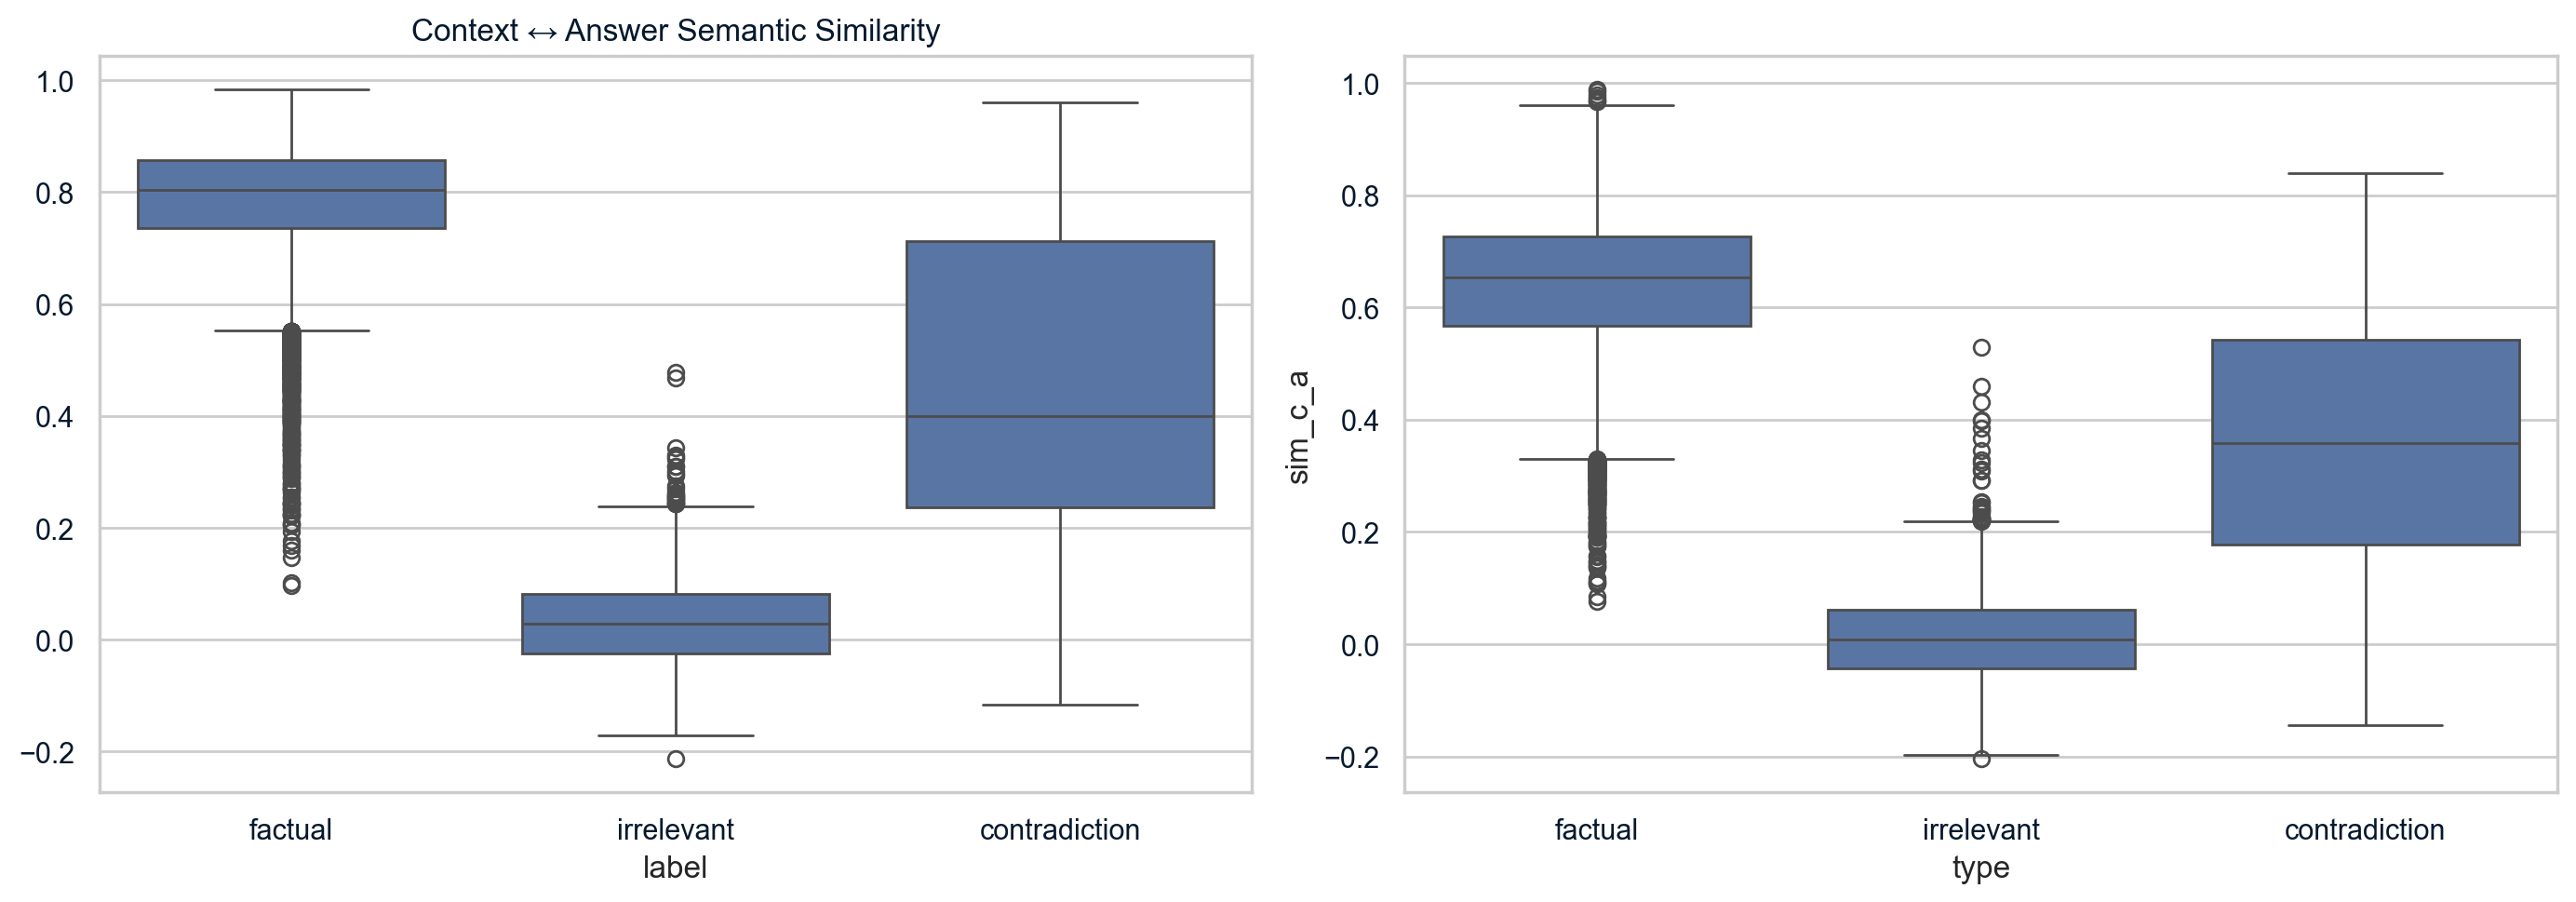

In [11]:
# cosine similarity
train_df['sim_q_a'] = util.cos_sim(question_embeddings, answer_embeddings).diagonal().cpu().numpy()
train_df['sim_c_a'] = util.cos_sim(context_embeddings, answer_embeddings).diagonal().cpu().numpy()

# Visualize semantic similarity
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.boxplot(
    x='type',
    y='sim_q_a',
    data=train_df,
    ax=axes[0]
)
axes[0].set_title('Question ↔ Answer Semantic Similarity')
axes[0].set_xlabel('label')
axes[0].set_ylabel('Cosine Similarity')

sns.boxplot(
    x='type',
    y='sim_c_a',
    data=train_df,
    ax=axes[1]
)
axes[0].set_title('Context ↔ Answer Semantic Similarity')
axes[0].set_xlabel('label')
axes[0].set_ylabel('')
plt.tight_layout()
plt.show()

# Modeling

In [12]:
# Model 1
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

In [13]:
# prepare input text
train_df['text_concat'] = (
    train_df['question'].fillna('') + '' +
    train_df['context'].fillna('') + '' +
    train_df['answer'].fillna('')
)

x = train_df['text_concat']
y = train_df['label']

# Train/ validation split
X_train, X_val, y_train, y_val = train_test_split(
    x,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [14]:
# TF - IDF Vectorization
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=100_000,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Train Logistic Regression
clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced'  # <-- Fixed argument name
)

clf.fit(X_train_tfidf, y_train)

# predictions
y_pred = clf.predict(X_val_tfidf)

In [15]:
# Evaluation (Hard numbers)

# accuracy
acc = accuracy_score(y_val, y_pred)

# Macro F1
macro_f1 = f1_score(y_val, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")

# Classification report
print('\nClassification report:')
print(classification_report(
    y_val,
    y_pred,
    target_names=['Factual', 'Contradiction', 'Irrelevant']
))


Accuracy: 0.6413
Macro F1: 0.3632

Classification report:
               precision    recall  f1-score   support

      Factual       0.84      0.73      0.78      3172
Contradiction       0.13      0.20      0.16       335
   Irrelevant       0.11      0.20      0.14       324

     accuracy                           0.64      3831
    macro avg       0.36      0.38      0.36      3831
 weighted avg       0.72      0.64      0.68      3831



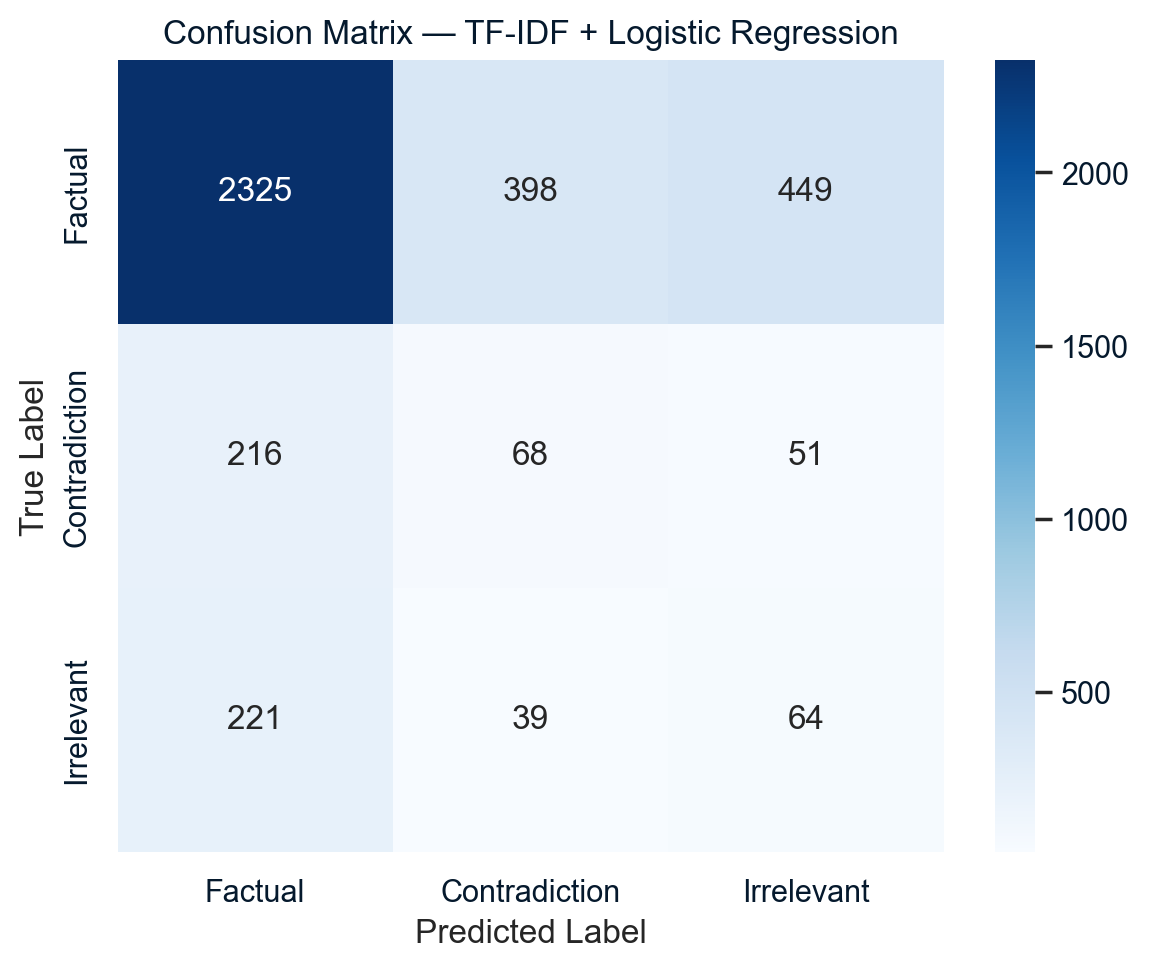

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Factual', 'Contradiction', 'Irrelevant'],
    yticklabels=['Factual', 'Contradiction', 'Irrelevant'],
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix — TF-IDF + Logistic Regression')
plt.tight_layout()
plt.show()

In [17]:
# Model 2
texts = [
    f"[QUESTION] {q} [CONTEXT] {c} [ANSWER] {a}"
    for q, c, a in zip(train_df["question"], train_df["context"], train_df["answer"])
]
labels = train_df["label"].values

X_train, X_val, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

Train size: 15321, Validation size: 3831


In [18]:
# Sentence Embeddings

from sentence_transformers import SentenceTransformer

# Fast, small embedding model
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_emb = embed_model.encode(X_train, convert_to_numpy=True)
X_val_emb   = embed_model.encode(X_val, convert_to_numpy=True)

print(f"Embedding dimension: {X_train_emb.shape[1]}")

Embedding dimension: 384


In [19]:
# Cosine similarity features
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# split original question/context/answer for similarity features
def split_qca(texts):
    q_list, c_list, a_list = [], [], []
    for t in texts:
        q_part = t.split('[CONTEXT]')[0].replace('[QUESTION]', '').strip()
        c_part = t.split('[ANSWER]')[0].split('[CONTEXT]')[1].strip()
        a_part = t.split('[ANSWER]')[1].strip()
        q_list.append(q_part)
        c_list.append(c_part)
        a_list.append(a_part)
    return q_list, c_list, a_list

q_train, c_train, a_train = split_qca(X_train)
q_val, c_val, a_val = split_qca(X_val)

# Encode individual parts
q_train_emb = embed_model.encode(q_train, convert_to_numpy=True)
c_train_emb = embed_model.encode(c_train, convert_to_numpy=True)
a_train_emb = embed_model.encode(a_train, convert_to_numpy=True)

q_val_emb = embed_model.encode(q_val, convert_to_numpy=True)
c_val_emb = embed_model.encode(c_val, convert_to_numpy=True)
a_val_emb = embed_model.encode(a_val, convert_to_numpy=True)

# Cosine similarities: question-answer and context-answer
sim_qa_train = np.array([cosine_similarity([q_train_emb[i]], [a_train_emb[i]])[0][0] for i in range(len(q_train_emb))]).reshape(-1,1)
sim_ca_train = np.array([cosine_similarity([c_train_emb[i]], [a_train_emb[i]])[0][0] for i in range(len(c_train_emb))]).reshape(-1,1)

sim_qa_val = np.array([cosine_similarity([q_val_emb[i]], [a_val_emb[i]])[0][0] for i in range(len(q_val_emb))]).reshape(-1,1)
sim_ca_val = np.array([cosine_similarity([c_val_emb[i]], [a_val_emb[i]])[0][0] for i in range(len(c_val_emb))]).reshape(-1,1)

# Concatenate embeddings + similarity features
X_train_final = np.hstack([X_train_emb, sim_qa_train, sim_ca_train])
X_val_final   = np.hstack([X_val_emb, sim_qa_val, sim_ca_val])

print(f"Final feature dimension: {X_train_final.shape[1]}")

Final feature dimension: 386


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_val_final   = scaler.transform(X_val_final)

print("Features scaled.")

Features scaled.


In [21]:
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_final, y_train)

print("Model trained.")

Model trained.


Classification Report:

              precision    recall  f1-score   support

           0     0.9571    0.9909    0.9737      3172
           1     0.6781    0.4716    0.5563       335
           2     0.8822    0.8549    0.8683       324

    accuracy                         0.9340      3831
   macro avg     0.8391    0.7725    0.7994      3831
weighted avg     0.9263    0.9340    0.9283      3831



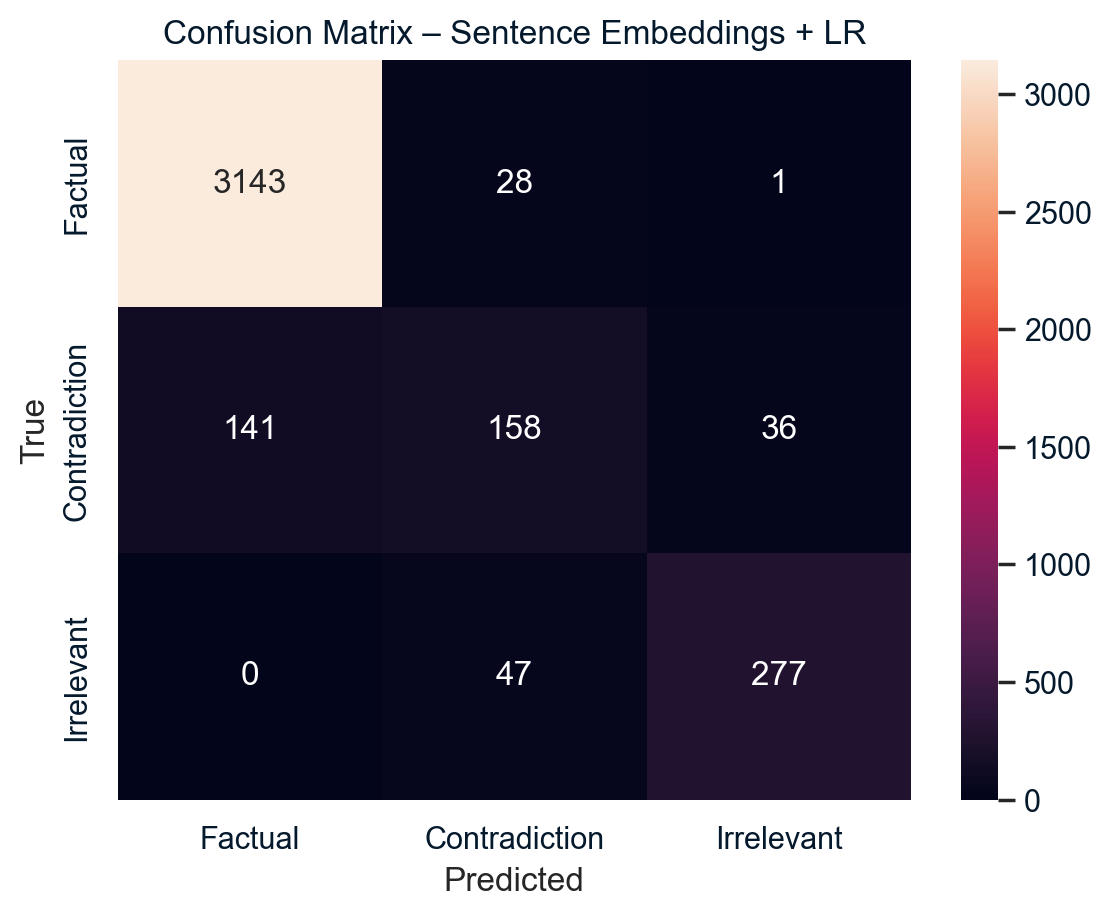

In [22]:
y_pred = clf.predict(X_val_final)

print("Classification Report:\n")
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Factual", "Contradiction", "Irrelevant"],
    yticklabels=["Factual", "Contradiction", "Irrelevant"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Sentence Embeddings + LR")
plt.show()

In [23]:
# Predicting labels with
import json

# Load test.json
with open("data/test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

test_df = pd.DataFrame(test_data)

print(f"Test size: {len(test_df)}")
test_df.head()

Test size: 2000


,ID,answer,type,context,question
0,1,"In the mid-19th century, the Bronx was referre...",,The Bronx street grid is irregular. Like the n...,What was the Bronx called in the mid-19th cent...
1,2,"Beyoncé's father, Mathew Knowles, began managi...",,,When did Beyoncé begin to manage the girl group?
2,3,Dionysus was similar to the Roman god Bacchus.,,"While the new plebeian nobility made social, p...",To what Roman god was Dionysus similar?
3,4,The most crucial defense in preventing the spr...,,"Techniques like hand washing, wearing gowns, a...",What is the most important defense against the...
4,5,The third largest long term acute care provide...,,The Baylor College of Medicine has annually be...,What is the third largest acute care center in...


In [24]:
# Build Test Inputs
X_test = [
    f"[QUESTION] {q} [CONTEXT] {c} [ANSWER] {a}"
    for q, c, a in zip(test_df["question"], test_df["context"], test_df["answer"])
]

print("Sample test input:")
print(X_test[0])

Sample test input:
[QUESTION] What was the Bronx called in the mid-19th century? [CONTEXT] The Bronx street grid is irregular. Like the northernmost part of upper Manhattan, the West Bronx's hilly terrain leaves a relatively free-style street grid. Much of the West Bronx's street numbering carries over from upper Manhattan, but does not match it exactly; East 132nd Street is the lowest numbered street in the Bronx. This dates from the mid-19th century when the southwestern area of Westchester County west of the Bronx River, was incorporated into New York City and known as the Northside. [ANSWER] In the mid-19th century, the Bronx was referred to as the Northside.


In [25]:
# Sentence Embeddings (Test)

X_test_emb = embed_model.encode(X_test, convert_to_numpy=True)

print(f"Test embedding shape: {X_test_emb.shape}")


Test embedding shape: (2000, 384)


In [26]:
# Cosine Similarity Features (Test)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def split_qca(texts):
    q_list, c_list, a_list = [], [], []
    for t in texts:
        q_part = t.split('[CONTEXT]')[0].replace('[QUESTION]', '').strip()
        c_part = t.split('[ANSWER]')[0].split('[CONTEXT]')[1].strip()
        a_part = t.split('[ANSWER]')[1].strip()
        q_list.append(q_part)
        c_list.append(c_part)
        a_list.append(a_part)
    return q_list, c_list, a_list

q_test, c_test, a_test = split_qca(X_test)

q_test_emb = embed_model.encode(q_test, convert_to_numpy=True)
c_test_emb = embed_model.encode(c_test, convert_to_numpy=True)
a_test_emb = embed_model.encode(a_test, convert_to_numpy=True)

sim_qa_test = np.array([
    cosine_similarity([q_test_emb[i]], [a_test_emb[i]])[0][0]
    for i in range(len(q_test_emb))
]).reshape(-1, 1)

sim_ca_test = np.array([
    cosine_similarity([c_test_emb[i]], [a_test_emb[i]])[0][0]
    for i in range(len(c_test_emb))
]).reshape(-1, 1)

X_test_final = np.hstack([X_test_emb, sim_qa_test, sim_ca_test])

print(f"Final test feature shape: {X_test_final.shape}")

Final test feature shape: (2000, 386)


In [27]:
# Applying Scaling

X_test_final = scaler.transform(X_test_final)

print('Test features scaled.')

Test features scaled.


In [28]:
# Predict test labels
test_preds = clf.predict(X_test_final)

# check label distribution
unique, counts = np.unique(test_preds, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(1610), np.int64(1): np.int64(215), np.int64(2): np.int64(175)}


In [29]:
submission = pd.DataFrame({
    'id': test_df['ID'],
    'label': test_preds
})

submission.to_csv('submission_model2_embeddings.csv', index=False)

submission.head()

,id,label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [30]:
# Model 3: Stage 1

# Stage-1 Labels

stage1_df = train_df.copy()

stage1_df["stage1_label"] = stage1_df["type"].map({
    "irrelevant": 0,
    "factual": 1,
    "contradiction": 1
})

stage1_df["stage1_label"].value_counts()

stage1_label
1    17530
0     1622
Name: count, dtype: int64

In [31]:
# Stage-1 Text Input
X_stage1 = [
    f"{q} {a}"
    for q, a in zip(stage1_df["question"], stage1_df["answer"])
]

y_stage1 = stage1_df["stage1_label"].values

print(X_stage1[0])

In what year did Parliament pass a notable law that led to the building of fortifications in Plymouth? In 1512, Parliament passed a significant act that resulted in the construction of fortifications in Plymouth.


In [32]:
# Embeddings
X_stage1_emb = embed_model.encode(
    X_stage1,
    convert_to_numpy=True,
    show_progress_bar=True
)

X_stage1_emb.shape

Batches:   0%|          | 0/599 [00:00<?, ?it/s]

(19152, 384)

In [33]:
# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

q_emb = embed_model.encode(stage1_df["question"].tolist(), convert_to_numpy=True)
a_emb = embed_model.encode(stage1_df["answer"].tolist(), convert_to_numpy=True)

sim_qa = np.array([
    cosine_similarity([q_emb[i]], [a_emb[i]])[0][0]
    for i in range(len(q_emb))
]).reshape(-1, 1)

X_stage1_final = np.hstack([X_stage1_emb, sim_qa])

X_stage1_final.shape

(19152, 385)

In [34]:
# Train/Validation Split
X1_train, X1_val, y1_train, y1_val = train_test_split(
    X_stage1_final,
    y_stage1,
    test_size=0.2,
    stratify=y_stage1,
    random_state=42
)

In [35]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler_stage1 = StandardScaler()
X1_train = scaler_stage1.fit_transform(X1_train)
X1_val = scaler_stage1.transform(X1_val)

In [36]:
# Train Stage-1 Model
from sklearn.linear_model import LogisticRegression

stage1_clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

stage1_clf.fit(X1_train, y1_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [37]:
# Evaluation

from sklearn.metrics import classification_report, confusion_matrix

y1_pred = stage1_clf.predict(X1_val)

print(classification_report(y1_val, y1_pred, target_names=["Irrelevant", "Relevant"]))
confusion_matrix(y1_val, y1_pred)

              precision    recall  f1-score   support

  Irrelevant       0.93      0.97      0.95       324
    Relevant       1.00      0.99      1.00      3507

    accuracy                           0.99      3831
   macro avg       0.96      0.98      0.97      3831
weighted avg       0.99      0.99      0.99      3831



array([[ 315,    9],
       [  25, 3482]])

In [38]:
# Stage 2.
# Filter Relevant Samples for Stage 2

# Use stage1 labels from training data
relevant_mask = stage1_df["stage1_label"] == 1
stage2_df = stage1_df[relevant_mask].copy()

# Map Factual -> 1, Contradiction -> 0
stage2_df["stage2_label"] = stage2_df["type"].map({
    "factual": 1,
    "contradiction": 0
})

stage2_df["stage2_label"].value_counts()

stage2_label
1    15858
0     1672
Name: count, dtype: int64

In [39]:
# Stage-2 Text Input
X_stage2 = [
    f"[QUESTION] {q} [CONTEXT] {c} [ANSWER] {a}"
    for q, c, a in zip(stage2_df["question"], stage2_df["context"], stage2_df["answer"])
]

y_stage2 = stage2_df["stage2_label"].values

print(X_stage2[0])

[QUESTION] In what year did Parliament pass a notable law that led to the building of fortifications in Plymouth? [CONTEXT] During the Hundred Years' War a French attack (1340) burned a manor house and took some prisoners, but failed to get into the town. In 1403 the town was burned by Breton raiders. In the late fifteenth century a 'castle quadrate' was constructed close to the area now known as The Barbican; it included four round towers, one at each corner, as featured on the city coat of arms. The castle served to protect Sutton Pool, which is where the fleet was based in Plymouth prior to the establishment of Plymouth Dockyard. In 1512 an Act of Parliament was passed for further fortifying Plymouth, and a series of fortifications were then built, including defensive walls at the entrance to Sutton Pool (across which a chain would be extended in time of danger). Defences on St Nicholas Island also date from this time, and a string of six artillery blockhouses were built, including 

In [40]:
# Stage-2 Embeddings
X_stage2_emb = embed_model.encode(
    X_stage2,
    convert_to_numpy=True,
    show_progress_bar=True
)

print(f"Stage 2 embeddings shape: {X_stage2_emb.shape}")

Batches:   0%|          | 0/548 [00:00<?, ?it/s]

Stage 2 embeddings shape: (17530, 384)


In [41]:
# Cosine Similarity Features
q_emb = embed_model.encode(stage2_df["question"].tolist(), convert_to_numpy=True)
c_emb = embed_model.encode(stage2_df["context"].tolist(), convert_to_numpy=True)
a_emb = embed_model.encode(stage2_df["answer"].tolist(), convert_to_numpy=True)

sim_qa = np.array([
    cosine_similarity([q_emb[i]], [a_emb[i]])[0][0]
    for i in range(len(q_emb))
]).reshape(-1,1)

sim_ca = np.array([
    cosine_similarity([c_emb[i]], [a_emb[i]])[0][0]
    for i in range(len(c_emb))
]).reshape(-1,1)

X_stage2_final = np.hstack([X_stage2_emb, sim_qa, sim_ca])
print(f"Stage 2 final features shape: {X_stage2_final.shape}")

Stage 2 final features shape: (17530, 386)


In [42]:
# Train / Validation Split
from sklearn.model_selection import train_test_split

X2_train, X2_val, y2_train, y2_val = train_test_split(
    X_stage2_final,
    y_stage2,
    test_size=0.2,
    stratify=y_stage2,
    random_state=42
)

In [43]:
#Scaling
scaler_stage2 = StandardScaler()
X2_train = scaler_stage2.fit_transform(X2_train)
X2_val = scaler_stage2.transform(X2_val)

In [44]:
# Train Stage-2 Model
stage2_clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

stage2_clf.fit(X2_train, y2_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


               precision    recall  f1-score   support

Contradiction       0.42      0.81      0.55       334
      Factual       0.98      0.88      0.93      3172

     accuracy                           0.87      3506
    macro avg       0.70      0.85      0.74      3506
 weighted avg       0.92      0.87      0.89      3506



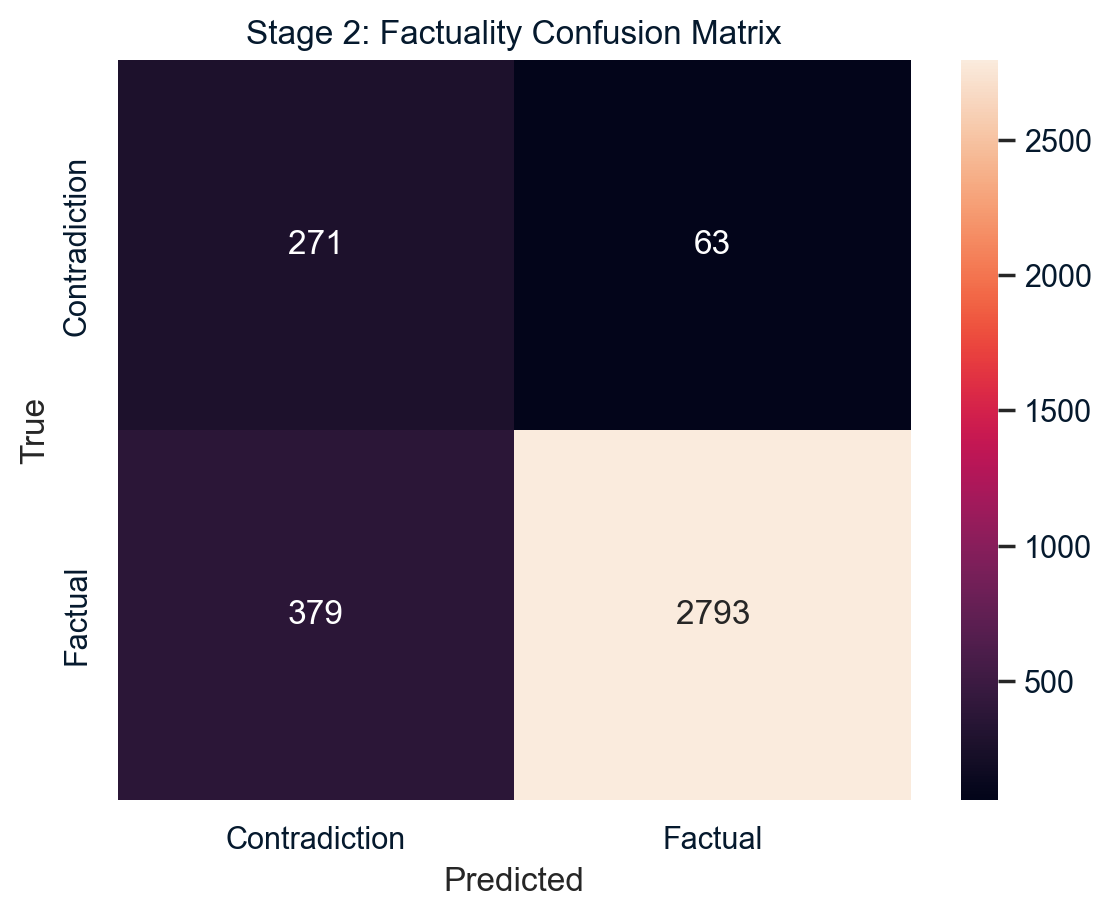

In [45]:
# Evaluation
y2_pred = stage2_clf.predict(X2_val)

print(classification_report(y2_val, y2_pred, target_names=["Contradiction", "Factual"]))

cm = confusion_matrix(y2_val, y2_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Contradiction", "Factual"],
    yticklabels=["Contradiction", "Factual"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Stage 2: Factuality Confusion Matrix")
plt.show()

In [46]:
# Cell 9: Combined Prediction Function
def predict_two_stage(questions, contexts, answers):
    texts_stage1 = [f"{q} {a}" for q, a in zip(questions, answers)]
    emb_stage1 = embed_model.encode(texts_stage1, convert_to_numpy=True)
    q_emb_stage1 = embed_model.encode(questions, convert_to_numpy=True)
    a_emb_stage1 = embed_model.encode(answers, convert_to_numpy=True)
    sim_qa_stage1 = np.array([cosine_similarity([q_emb_stage1[i]], [a_emb_stage1[i]])[0][0] for i in range(len(q_emb_stage1))]).reshape(-1,1)
    X_stage1_pred = np.hstack([emb_stage1, sim_qa_stage1])
    X_stage1_pred = scaler_stage1.transform(X_stage1_pred)
    
    stage1_preds = stage1_clf.predict(X_stage1_pred)
    
    final_preds = []
    
    for i, s1 in enumerate(stage1_preds):
        if s1 == 0:
            final_preds.append("irrelevant")
        else:
            # Stage 2
            text_s2 = f"[QUESTION] {questions[i]} [CONTEXT] {contexts[i]} [ANSWER] {answers[i]}"
            emb_s2 = embed_model.encode([text_s2], convert_to_numpy=True)
            sim_qa_s2 = cosine_similarity([embed_model.encode([questions[i]], convert_to_numpy=True)[0]], [embed_model.encode([answers[i]], convert_to_numpy=True)[0]])[0][0]
            sim_ca_s2 = cosine_similarity([embed_model.encode([contexts[i]], convert_to_numpy=True)[0]], [embed_model.encode([answers[i]], convert_to_numpy=True)[0]])[0][0]
            X_s2 = np.hstack([emb_s2, [[sim_qa_s2, sim_ca_s2]]])
            X_s2 = scaler_stage2.transform(X_s2)
            s2_pred = stage2_clf.predict(X_s2)[0]
            final_preds.append("factual" if s2_pred == 1 else "contradiction")
    
    return final_preds

In [47]:
# Loading Test Data:
with open("data/test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

test_df = pd.DataFrame(test_data)
print(f"Test set size: {len(test_df)}")
test_df.head()

Test set size: 2000


,ID,answer,type,context,question
0,1,"In the mid-19th century, the Bronx was referre...",,The Bronx street grid is irregular. Like the n...,What was the Bronx called in the mid-19th cent...
1,2,"Beyoncé's father, Mathew Knowles, began managi...",,,When did Beyoncé begin to manage the girl group?
2,3,Dionysus was similar to the Roman god Bacchus.,,"While the new plebeian nobility made social, p...",To what Roman god was Dionysus similar?
3,4,The most crucial defense in preventing the spr...,,"Techniques like hand washing, wearing gowns, a...",What is the most important defense against the...
4,5,The third largest long term acute care provide...,,The Baylor College of Medicine has annually be...,What is the third largest acute care center in...


In [48]:
# Generate Predictions

questions_test = test_df["question"].tolist()
contexts_test = test_df["context"].tolist()
answers_test = test_df["answer"].tolist()

# Predict using the two-stage system
final_test_preds = predict_two_stage(questions_test, contexts_test, answers_test)

# Optional: quick sanity check
from collections import Counter
Counter(final_test_preds)

Counter({'factual': 1370, 'contradiction': 438, 'irrelevant': 192})

In [50]:
# Save Submission CSV

submission = pd.DataFrame({
    "id": test_df["ID"],
    "label": final_test_preds
})

submission_file = "submission_model3_two_stage.csv"
submission.to_csv(submission_file, index=False)
print(f"Submission saved as: {submission_file}")
submission.head()

Submission saved as: submission_model3_two_stage.csv


,id,label
0,1,factual
1,2,contradiction
2,3,factual
3,4,factual
4,5,factual
